In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.cnn import *
from model.gru import *
from model.lstm import *
from model.metrics import *
from model.unet import *

In [2]:
#import data
bnp_data = pd.read_csv("../cleaned_data.csv")
bnp_data = add_features(bnp_data, window_sizes=[5, 10])
bnp_data['Close_diff'] = bnp_data['Close'].diff()
bnp_data = bnp_data.dropna()
bnp_data.describe()

,Adj Close,Close,High,Low,Open,Volume,Log Return,ma_close_5,ma_volume_5,ma_close_10,ma_volume_10,Close_diff
count,3042.000000,3042.000000,3042.000000,3042.000000,3042.000000,3.042000e+03,3042.000000,3042.000000,3.042000e+03,3042.000000,3.042000e+03,3042.000000
mean,36.474909,52.144128,52.756066,51.540008,52.163665,3.990027e+06,0.000325,36.449195,3.990251e+06,36.415691,3.991340e+06,0.005460
std,11.220698,8.748133,8.709293,8.762474,8.731542,1.962654e+06,0.019518,11.190147,1.526491e+06,11.150063,1.384976e+06,0.927804
min,17.095335,24.670000,25.340000,24.504999,24.900000,0.000000e+00,-0.191166,17.500025,9.809828e+05,18.094585,1.360922e+06,-8.299999
25%,28.007760,45.731250,46.424998,45.169998,45.807500,2.753294e+06,-0.009229,28.020030,3.008809e+06,28.030612,3.118829e+06,-0.500000
50%,33.482998,52.700001,53.234999,52.105000,52.725000,3.558994e+06,0.000596,33.489456,3.769833e+06,33.402609,3.781142e+06,0.027500
75%,41.961139,58.599998,59.250000,58.029999,58.689999,4.683142e+06,0.010277,41.963657,4.614389e+06,42.057052,4.560692e+06,0.539997
max,68.339996,72.900002,73.080002,72.290001,72.349998,2.133924e+07,0.165351,67.799724,1.422400e+07,67.577721,1.246760e+07,5.975002


In [3]:
features=['Close_diff', 'Close', 'Volume','Log Return','ma_close_10','ma_volume_5']

gap = 10  # Gap between each subset

total_samples = len(bnp_data)
train_size = int(0.60 * total_samples)
test_size = int(0.19 * total_samples)
validation_size = int(0.19 * total_samples)

train,test,validation=data_splitting(bnp_data,train_size,test_size,validation_size,gap)

In [4]:
# Scaler for the target to inverse transform y_pred 
target = train[['Close_diff']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scaler for the training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[features])
scaled_train = pd.DataFrame(scaled_train, columns=features)

# Applying the scaler of the training set onto test and validation set
scaled_test = scaler.transform(test[features])
scaled_test = pd.DataFrame(scaled_test, columns=features)

scaled_validation = scaler.transform(validation[features])
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

In [5]:
timesteps = 10
X_train, y_train = create_sequences(scaled_train, target_column='Close_diff', timesteps=timesteps)
X_test, y_test = create_sequences(scaled_test, target_column='Close_diff', timesteps=timesteps)
X_validation, y_validation = create_sequences(scaled_validation, target_column='Close_diff', timesteps=timesteps)

In [6]:
# Build and train the LSTM model
model = build_deeper_lstm_model((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitors the validation loss
    patience=10,            # Number of epochs with no improvement after which training stops
    min_delta=0.001,        # Minimum improvement in loss to qualify as progress
    restore_best_weights=True  # Restores weights from the best epoch
)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),callbacks=[early_stopping])


ValueError: Layers added to a Sequential model can only have a single positional argument, the input tensor. Layer MultiHeadAttention has multiple positional arguments: [<Parameter "query">, <Parameter "value">]

In [55]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 1.1143
NSE: -0.0098


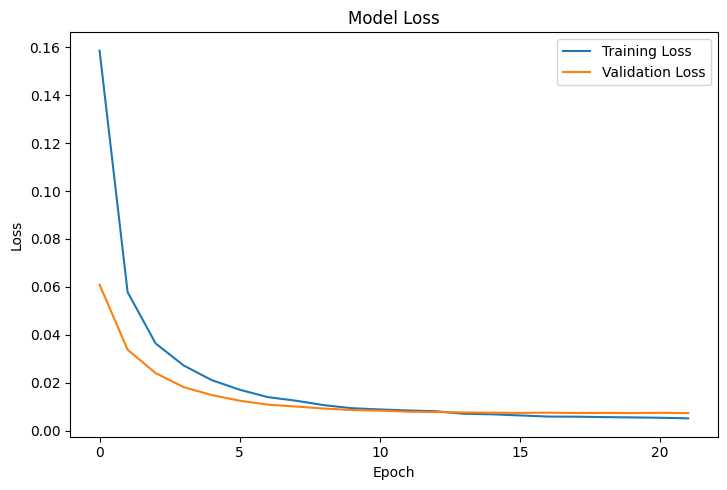

In [56]:
plot_learning_curves(history)

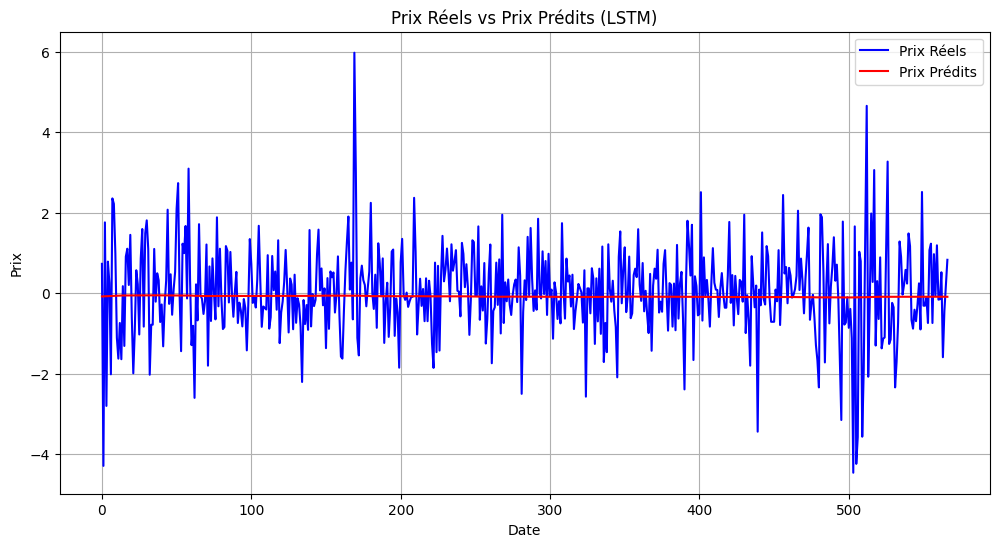

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()